# **Introduction**

## Importing the required modules

In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import os, time, warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)
import tkinter as tk
from tkinter import messagebox
warnings.filterwarnings("ignore")

In [2]:
log_cols = ["model", "accuracy", "train_time", "pred_time"]
log = pd.DataFrame(columns=log_cols)

## Reading the data

In [3]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [4]:
esc50_csv = './datasets/ESC-50-master/ESC-50-master/meta/file.csv'
base_data_path = './datasets/ESC-50-master/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,non_related,True,100032,A
1,1-100038-A-14.wav,1,14,non_related,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,non_related,False,101296,A


In [5]:
my_classes = ['vacuum_cleaner', 'keyboard_typing','washing_machine','clock_tick','door_wood_knock','mouse_click','door_wood_creaks','can_opening','clock_alarm','glass_breaking','non_related']
map_class_to_id = {'vacuum_cleaner':0, 'keyboard_typing':1,'washing_machine':2,'clock_tick':3,'door_wood_knock':4,'mouse_click':5,'door_wood_creaks':6,'can_opening':7,'clock_alarm':8,'glass_breaking':9,'non_related':10}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(4)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/ESC-50-master/audio/1...,1,10,non_related,True,100032,A
1,./datasets/ESC-50-master/ESC-50-master/audio/1...,1,10,non_related,False,100038,A
2,./datasets/ESC-50-master/ESC-50-master/audio/1...,1,0,vacuum_cleaner,False,100210,A
3,./datasets/ESC-50-master/ESC-50-master/audio/1...,1,0,vacuum_cleaner,False,100210,B


In [6]:


# Define a function to modify a specific cell
def modify_cell(category):
    if category not in my_classes:
        return 'non_related'
    else:
        return category

# Apply the function to the specific column
pd_data['category'] = pd_data['category'].apply(modify_cell)


In [7]:
pd_data['category'].unique()

array(['non_related', 'vacuum_cleaner', 'door_wood_knock', 'can_opening',
       'mouse_click', 'clock_alarm', 'keyboard_typing', 'glass_breaking',
       'washing_machine', 'clock_tick', 'door_wood_creaks'], dtype=object)

In [8]:
filtered_pd.groupby("target")["category"].unique()

target
0       [vacuum_cleaner]
1      [keyboard_typing]
2      [washing_machine]
3           [clock_tick]
4      [door_wood_knock]
5          [mouse_click]
6     [door_wood_creaks]
7          [can_opening]
8          [clock_alarm]
9       [glass_breaking]
10         [non_related]
Name: category, dtype: object

[ 0  1  2  3  4  5  6  7  8  9 10]
Axes(0.125,0.11;0.775x0.77)


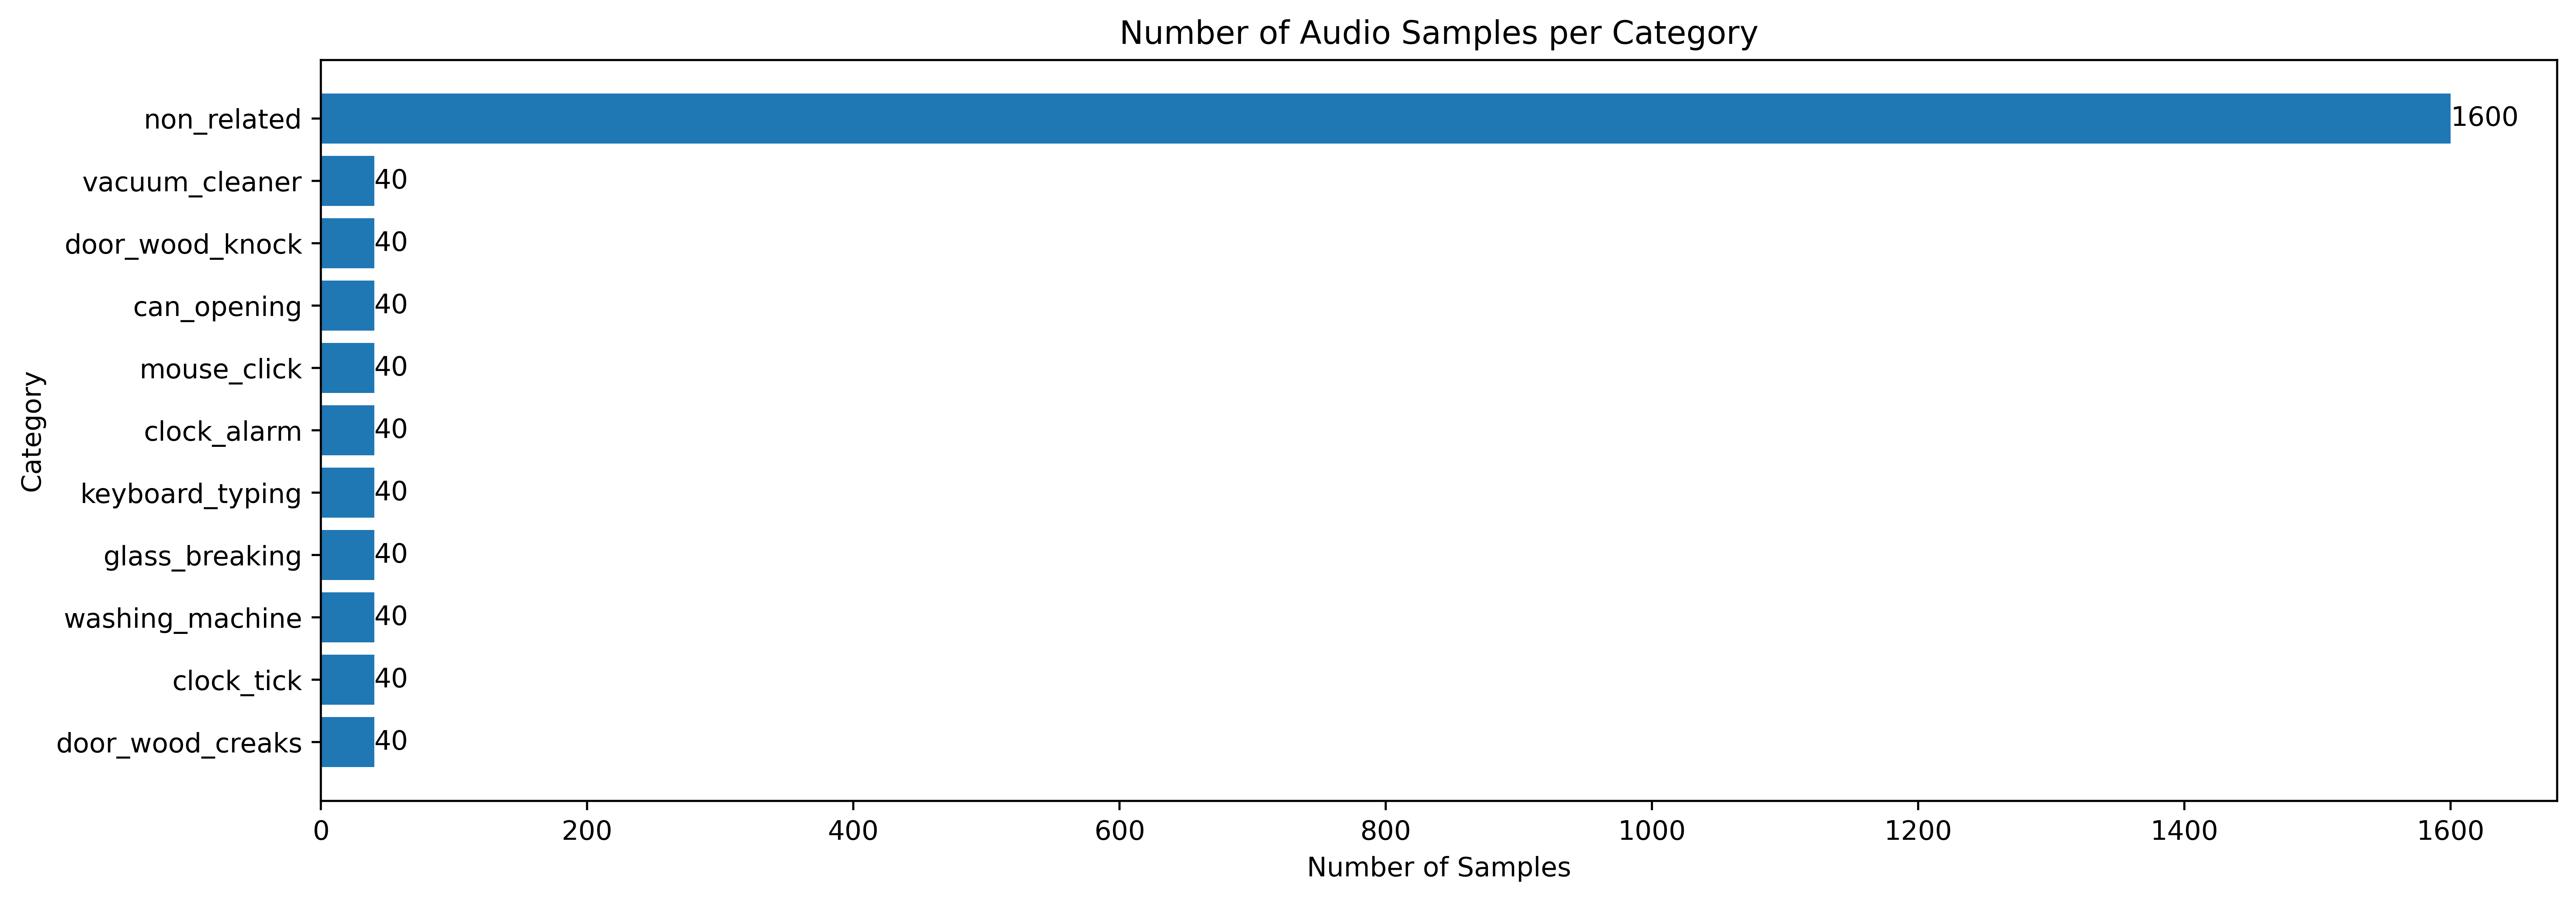

In [9]:
x = filtered_pd["category"].unique()
y = filtered_pd["category"].value_counts(ascending=True)
ind = np.arange(len(y))
print(ind)
# plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
print(ax)
ax.barh(ind, y)
ax.set_yticks(ind[::-1])
ax.set_yticklabels(x)
ax.bar_label(ax.containers[0])
plt.gcf().set_dpi(500)
plt.title("Number of Audio Samples per Category")
plt.xlabel("Number of Samples")
plt.ylabel("Category")
plt.show()

# **MFCC Visualization**


In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def spec(path):
    audio_sig, sampling_rate = librosa.load(path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_sig, sr=sampling_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    fig, ax = plt.subplots(figsize=(6, 3))
    img = librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title('Mel Spectrogram', fontsize=16)
    plt.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.savefig('MelSpectrogram.png')
    plt.show()




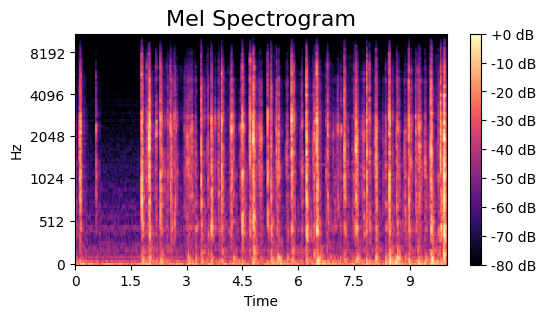

In [11]:
spec(r'C:\Users/ajays\OneDrive\Pictures\DSP\datasets\ESC-50-master\ESC-50-master/audio/1-137-A-32.wav')

# **MFCC Visualization**

1. I have used Librosa to preprocess audio file.
2. To do so, I will go through each fold and extract the data from each file using librosa's mfcc function.
3. The extracted data is appended in a list and stored in a dataframe.

### The function bellow will extract mfcc feature

In [12]:
extracted = []
for index_num, row in tqdm(filtered_pd.iterrows()):
    # get the file
    file_name = os.path.join(
        os.path.abspath(r"C:\Users/ajays\OneDrive\Pictures\DSP"),
        str(row["filename"]),)
    
    final_class_labels = row["category"]
    audio, sample_rate = librosa.load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    scaled_feature = np.mean(mel_spectrogram_db.T, axis=0)
    extracted.append([scaled_feature, final_class_labels])

849it [00:28, 32.85it/s]

### Using a dataframe and pickle to save the extracted features array


In [ ]:
# create a new dataframe
extracted_df = pd.DataFrame(extracted, columns=["feature", "class"])
# Storing the dataframe to pickle for further processing
extracted_df.to_pickle("extracted_df.pkl")
extracted_df.head()

,feature,class
0,"[-79.45175, -79.00692, -78.65766, -78.49657, -...",non_related
1,"[-78.34747, -77.51313, -76.7285, -75.988556, -...",non_related
2,"[-12.660118, -15.236122, -16.148817, -15.25955...",vacuum_cleaner
3,"[-9.792104, -12.582677, -16.137491, -18.060766...",vacuum_cleaner
4,"[-41.46884, -33.430515, -25.49058, -22.914333,...",non_related


# **Data Preprocessing**

## Distribute the data to X and Y


In [ ]:
final = pd.read_pickle("extracted_df.pkl")
X = np.array(final["feature"].tolist())
y = np.array(final["class"].tolist())

## Using LabelEncoder() to encode the string labels to an integer


In [ ]:
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))

## Split the data into train and test sets


In [ ]:
xTrainval, xTest, yTrainval, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387)
print("\nNumber of samples for Train set :", xTrain.shape[0])
print("Number of samples for Validation set :", xvalid.shape[0])
print("Number of samples for Test set :", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis=2)
xvalid = np.expand_dims(xvalid, axis=2)

print("Shape of X Train", yTrain.shape)
print("Shape of X Test", yTest.shape)


Number of samples for Train set : 1440
Number of samples for Validation set : 360
Number of samples for Test set : 200
Shape of X Train (1440, 11)
Shape of X Test (200, 11)


In [ ]:
xtrain = xTrain.reshape(xTrain.shape[0], 16, 8, -1)
xtest = xTest.reshape(xTest.shape[0], 16, 8, -1)
ytest = yTest.reshape(xTest.shape[0], 11, 1, -1)
print("The Shape of X Train", xtrain.shape)
print("The Shape of Y Train", yTrain.shape)
print("The Shape of X Test", xtest.shape)
print("The Shape of Y Test", yTest.shape)

The Shape of X Train (1440, 16, 8, 1)
The Shape of Y Train (1440, 11)
The Shape of X Test (200, 16, 8, 1)
The Shape of Y Test (200, 11)


## Split the data into train and test sets


## Building the model


In [ ]:
CNN2D_Model = Sequential()
CNN2D_Model.add(
    Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1))
)
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(1024, activation="tanh"))
CNN2D_Model.add(Dense(11, activation="softmax"))
CNN2D_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │        11,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,371 (4.33 MB)

 Trainable params: 1,135,371 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model


In [ ]:
CNN2D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

## Fitting the model


In [ ]:
t0 = time.time()

CNN2D_Results = CNN2D_Model.fit(
    xtrain, yTrain, epochs=250, batch_size=50, validation_data=(xtest, yTest)
)

CNN2D_Model.save("Model3.h5")
print("CNN2D Model Saved")
train_hist_m3 = pd.DataFrame(CNN2D_Results.history)
train_m3 = round(time.time() - t0, 3)

Epoch 1/250


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6756 - loss: 1.9755 - val_accuracy: 0.8000 - val_loss: 1.1027
Epoch 2/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7897 - loss: 1.0355 - val_accuracy: 0.8000 - val_loss: 0.9154
Epoch 3/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8078 - loss: 0.8543 - val_accuracy: 0.8050 - val_loss: 0.8283
Epoch 4/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8065 - loss: 0.8602 - val_accuracy: 0.8100 - val_loss: 0.7116
Epoch 5/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7981 - loss: 0.8119 - val_accuracy: 0.8050 - val_loss: 0.8912
Epoch 6/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8089 - loss: 0.8593 - val_accuracy: 0.8150 - val_loss: 0.7553
Epoch 7/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8183 - loss: 0.7312 - val_accuracy: 0.8050 - val_loss: 0.7236
Epoch 8/250
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8103 - loss: 0.7738 - val_accuracy: 0.8100 - val_l

CNN2D Model Saved


## Results


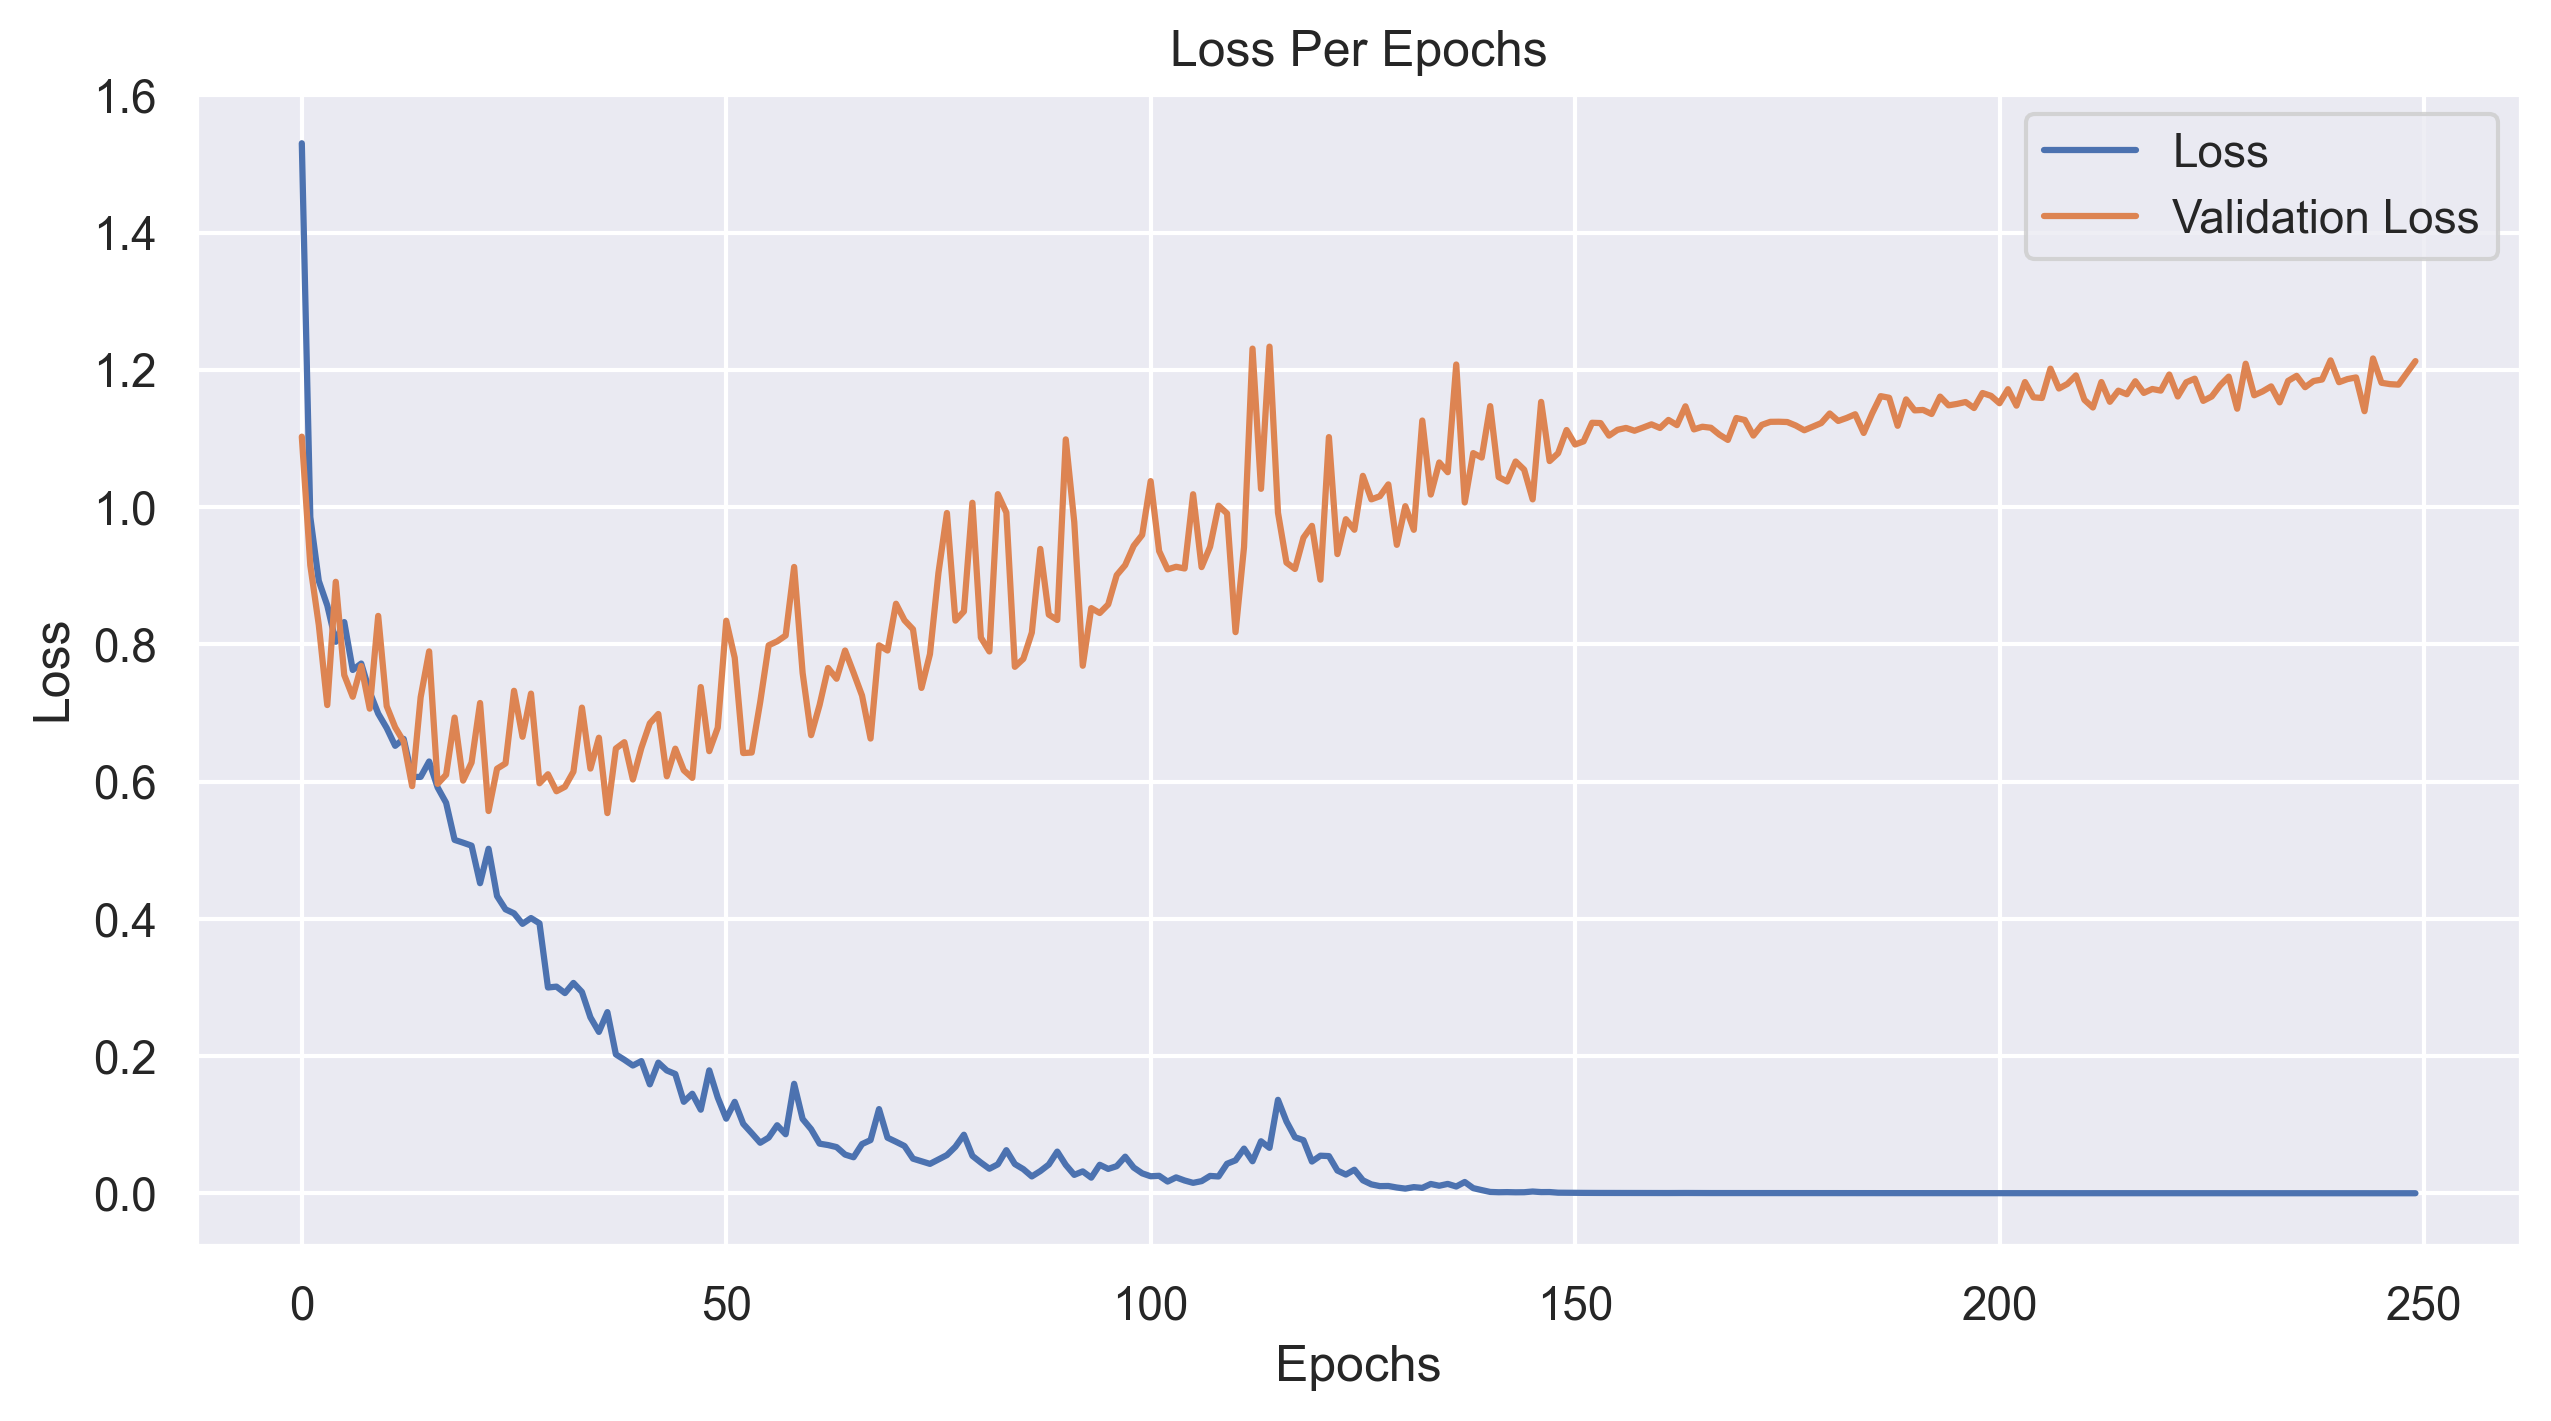

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

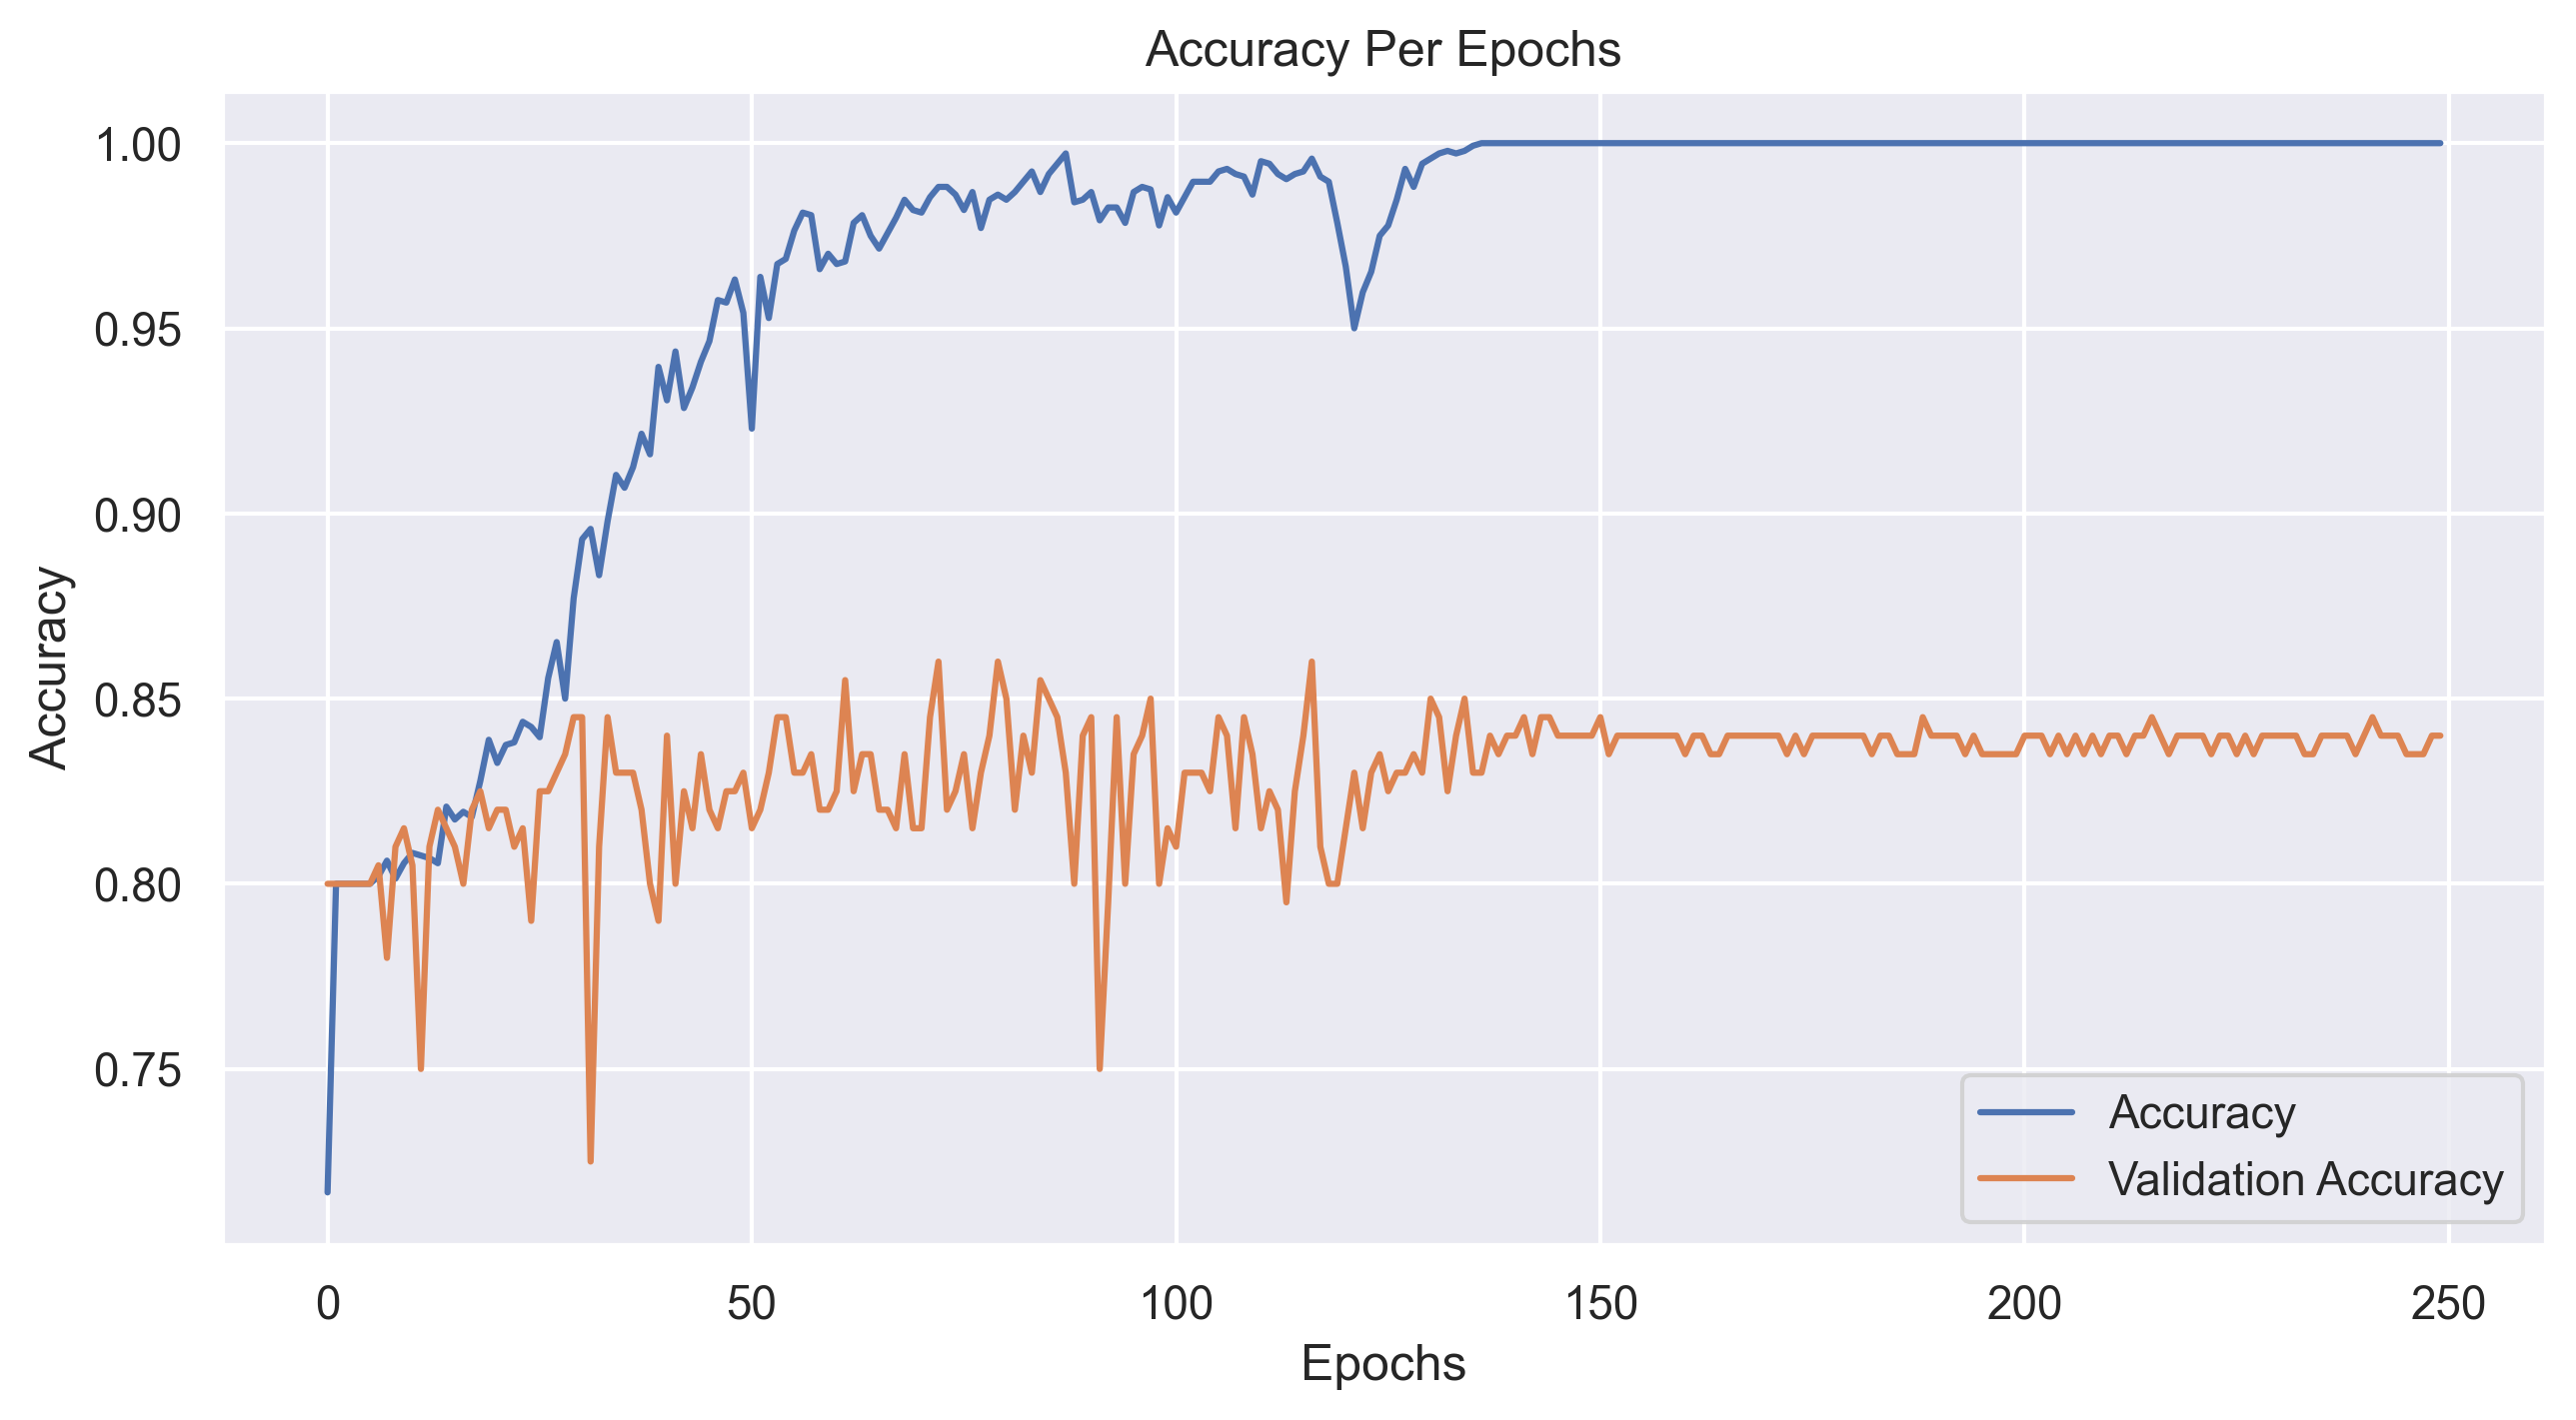

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
acc_m3 = CNN2D_Model.evaluate(xtest, yTest, verbose=0)
t0 = time.time()
y_pred_m3 = CNN2D_Model.predict(xtest, verbose=0)
pred_m3 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN2D", acc_m3[1] * 100, train_m3, pred_m3]], columns=log_cols
)
log = pd.concat([log,log_entry])

## CNN Prediction Function


In [ ]:
def CNN2D_Prediction(file_name):
    # load the audio file
    # audio_data, sample_rate = librosa.load(file_name)
    # get the feature
    audio, sample_rate = librosa.load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    scaled_feature = np.mean(mel_spectrogram_db.T, axis=0)
    # array of features
    prediction_feature = np.array([scaled_feature])
    # reshaping the features
    final_prediction_feature = prediction_feature.reshape(
        prediction_feature.shape[0], 16, 8, 1
    )
    # get the id of label using argmax
    predicted_vector = np.argmax(CNN2D_Model.predict(final_prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("CNN2D has predicted the class as  --> ", predicted_class)

## Testing the Model on Sample audio


In [ ]:
file_name = r'C:/Users/ajays/OneDrive/Pictures\DSP\datasets/ESC-50-master/ESC-50-master/audio/1-23996-A-35.wav'
# get the output
CNN2D_Prediction(file_name)
# play the file
ipd.Audio(file_name)
print(log)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
CNN2D has predicted the class as  -->  ['vacuum_cleaner']
   model   accuracy  train_time  pred_time
0  CNN2D  83.999997      76.841      0.118


In [ ]:
predicted_vector = np.argmax(CNN2D_Model.predict(xtest), axis=-1)
    # get the class label from class id
predicted_class = le.inverse_transform(predicted_vector)
    # display the result
print("CNN2D has predicted the class as  --> ", predicted_class)
print(len(xtest))
print(log)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
CNN2D has predicted the class as  -->  ['non_related' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'washing_machine' 'non_related' 'non_related' 'non_related'
 'non_related' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'non_related' 'non_related' 'non_related' 'can_opening'
 'non_related' 'non_related' 'non_related' 'washing_machine' 'non_related'
 'non_related' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'non_related' 'non_related' 'keyboard_typing'
 'door_wood_knock' 'non_related' 'non_related' 'non_related' 'non_related'
 'non_related' 'door_wood_creaks' 'non_related' 'non_related'
 'non_related' 'clock_alarm' 'non_related' 'non_related' 'non_related'
 'non_r

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Text(110.30937499999997, 0.5, 'Actual label')

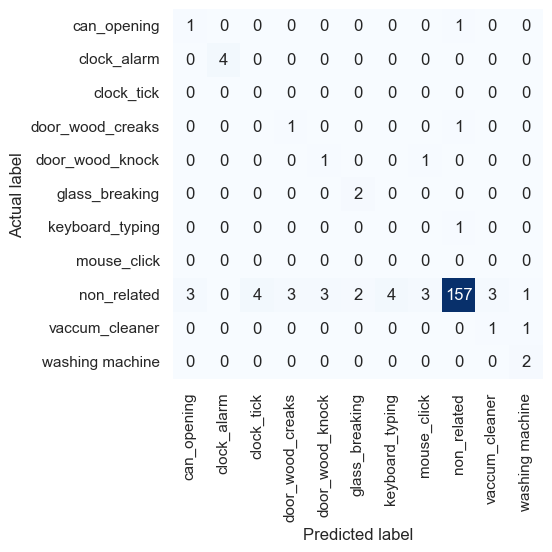

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = CNN2D_Model.predict(xtest)
mat = confusion_matrix(y_predicted.argmax(axis=1),yTest.argmax(axis=1))
class_labels = ['can_opening', 'clock_alarm', 'clock_tick', 'door_wood_creaks','door_wood_knock','glass_breaking','keyboard_typing','mouse_click','non_related','vaccum_cleaner','washing machine']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## GUI

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QLabel, QFileDialog
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt, QUrl
from PyQt5.QtMultimedia import QMediaPlayer, QMediaContent

import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

final = pd.read_pickle("extracted_df.pkl")
y = np.array(final["class"].tolist())

le = LabelEncoder()
Y = to_categorical(le.fit_transform(y))

model = tf.keras.models.load_model('Model3.h5')

def spec(path):
    audio_sig, sampling_rate = librosa.load(path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_sig, sr=sampling_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    fig, ax = plt.subplots(figsize=(6, 3))
    img = librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title('Mel Spectrogram', fontsize=16)
    plt.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.savefig('MelSpectrogram.png')
    plt.close()


def CNN2D_Prediction(file_name):
    audio, sample_rate = librosa.load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    scaled_feature = np.mean(mel_spectrogram_db.T, axis=0)
    # array of features
    prediction_feature = np.array([scaled_feature])
    # reshaping the features
    final_prediction_feature = prediction_feature.reshape(
        prediction_feature.shape[0], 16, 8, 1
    )
    # get the id of label using argmax
    predicted_vector = np.argmax(model.predict(final_prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("CNN2D has predicted the class as  --> ", predicted_class)
    return predicted_class

class MainWindow(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        self.setWindowTitle('Audio Player')
        self.setGeometry(100, 100, 500, 500)

        layout = QVBoxLayout()

        self.btn_open_audio = QPushButton('Open Audio')
        self.btn_play_pause = QPushButton('Play')
        self.btn_show_spectrogram = QPushButton('Show Spectrogram')
        self.btn_show_label = QPushButton('Show Label')

        layout.addWidget(self.btn_open_audio)
        layout.addWidget(self.btn_play_pause)
        layout.addWidget(self.btn_show_spectrogram)
        layout.addWidget(self.btn_show_label)

        self.image_label = QLabel()
        pixmap = QPixmap("example_image.png")
        self.image_label.setPixmap(pixmap)

        layout.addWidget(self.image_label)

        self.predict_label = QLabel('')

        layout.addWidget(self.predict_label)

        self.setLayout(layout)

        self.btn_open_audio.clicked.connect(self.open_audio_file)
        self.btn_play_pause.clicked.connect(self.toggle_play_pause)
        self.btn_show_spectrogram.clicked.connect(self.show_spectrogram)
        self.btn_show_label.clicked.connect(self.show_label_path)

        self.media_player = QMediaPlayer()
        self.show()

    def open_audio_file(self):
        file_dialog = QFileDialog()
        file_dialog.setNameFilter("Audio Files (*.mp3 *.wav)")
        if file_dialog.exec_():
            selected_files = file_dialog.selectedFiles()
            if selected_files:
                self.audio_file_path = selected_files[0]
                self.media_player.setMedia(QMediaContent(QUrl.fromLocalFile(self.audio_file_path)))

    def toggle_play_pause(self):
        # Toggle play/pause
        if self.media_player.state() == QMediaPlayer.PlayingState:
            self.media_player.pause()
            self.btn_play_pause.setText('Play')
        else:
            self.media_player.play()
            self.btn_play_pause.setText('Pause')

    def show_spectrogram(self):
        # Load and display spectrogram image
        spec(self.audio_file_path)
        spectrogram_image_path = "MelSpectrogram.png"  # Replace with your spectrogram image path
        spectrogram_pixmap = QPixmap(spectrogram_image_path)
        self.image_label.setPixmap(spectrogram_pixmap)

    def show_label_path(self):
        result = CNN2D_Prediction(self.audio_file_path)
        self.predict_label.setText(f'Predicted Sound is {result}')

if __name__ == '__main__':
    app = QApplication(sys.argv)
    mainWindow = MainWindow()
    sys.exit(app.exec_())
